`In this Kernel, I tried different methods for Credit Card Fraud Detection. `
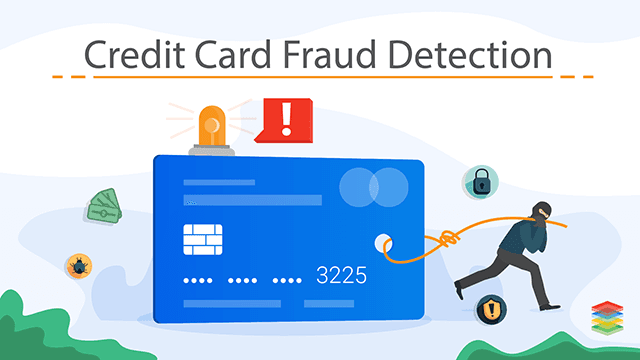

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact,  FloatSlider

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

In [ ]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.width=100
plt.style.use('ggplot')

In [ ]:
df = pd.read_csv('creditcard.csv')
df.head()

In [ ]:
df.shape

In [ ]:
df.isnull().sum().sum()

In [ ]:
df.describe()

In [ ]:
df.dtypes

In [ ]:
diff_class = df['Class'].value_counts()
diff_class.plot(kind='bar', color=['m', 'k'], figsize=(5, 5))
plt.xticks(range(2), ['Normal  [0]', 'Fraud  [1]'], rotation=0)
for i, v in enumerate(diff_class):
    plt.text(i-0.1, v+3000, str(v))
plt.title('Class Count')
plt.show()

In [ ]:
ss = StandardScaler()
df['Amount'] = ss.fit_transform(df[['Amount']])
df['Time'] = ss.fit_transform(df[['Time']])

Distribution of different columns.

In [ ]:
for var in df.columns[:-1]:
    
    sns.boxplot(df[var], hue=df['Class'], palette='Set3')
    mean = df[var].mean()
    std = df[var].std()
    plt.axvline(mean - 3 * std, 0, 1)
    plt.text(mean - 3 * std, -0.55, 'mean - 3* std', rotation=60)
    plt.axvline(mean + 3 * std, 0, 1)
    plt.text(mean + 3 * std, -0.55, 'mean + 3* std', rotation=60)
    

    plt.show()
    

Split the data in training and test set. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df[['Class']].values, test_size=0.3,random_state=1997)

 # 1. Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)

    labels_name = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    labels_count = [value for value in cf_matrix.flatten()]
    labels_percentage = [ "{0:.2%}".format(value) for value in cf_matrix.flatten()/ np.sum(cf_matrix)]

    labels = [f'{x}\n {y} \n{z}' for x, y, z in zip(labels_name, labels_count, labels_percentage)]
    labels = np.array(labels, dtype=str).reshape(2,2)

    recall = cf_matrix[1,1]/(cf_matrix[1,0] + cf_matrix[1,1])
    precision = cf_matrix[1,1]/(cf_matrix[0,1] + cf_matrix[1,1])
    accuracy = (cf_matrix[0, 0] + cf_matrix[1,1])/ np.sum(cf_matrix)
    f1_score = (2*precision*recall)/(precision + recall)

    stats = '\n\n Recall:   {0:.03}\n Precision:   {1:.03}\n Accuracy:  {2:.03}\nF1-Score:  {3:.03}'.format(recall, precision, accuracy, f1_score)

    sns.heatmap(cf_matrix, annot=labels, fmt='', center=3, linewidth=3, linecolor='k', cbar=False)
    plt.title('Confusion matrix\n', fontsize=20)
    plt.xlabel('Predicted Label'+stats, fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    plt.show()
plot_confusion_matrix(y_test, y_pred)


- __Upper Left Square__: The amount of correctly classified by model of no fraud transactions.
- __Upper Right Square__: The amount of incorrectly classified transactions as fraud cases, but the actual label is no fraud .
- __Lower Left Square__: The amount of incorrectly classified transactions as no fraud cases, but the actual label is fraud .
- __Lower Right Square__: The amount of correctly classified by our model of fraud transactions.


- *Recall*: Out of all the positive classes, how much we predicted correctly.  (TP/TP+FN)
- *Precision*: Out of all the positive classes we have predicted, how many are actually positive. (TP/TP+FP)
- *Accuracy*: Out of all the classes, how much we predicted correctly 
- *F-measure*: 2(Recall) (Precision)/(Recall + Precision)

# 2. Predict Proba

predict_proba gives you the probabilities for the target (0 and 1 in this case) in array form. The number of probabilities for each row is equal to the number of categories in target variable. 

In [ ]:
y_prob = lr.predict_proba(X_test)
y_prob = y_prob[:, 1] # Probability of getting the output 1 (Fraud)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('TPR vs FPR', fontsize=20)
plt.show()

In [ ]:
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_test, y_prob)
no_skill = len(y_test[y_test==1])/ len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_precision, lr_recall, marker='.', label='Logistic')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision vs Recall', fontsize=20)
plt.show()

# 3. Change the Threshold

In [ ]:
print("Slide, Range -> (0.001, 0.04)")
def update(var=0.004):
    print("y_prob should be greater than >", var)
    predict_mine = np.where(y_prob > var, 1, 0)
    plot_confusion_matrix(y_test, predict_mine)

interact(update, var=FloatSlider(min=0.001, max=0.04, step=0.001))

# 4. Logistic Regression with balanced class weight

In [ ]:
lr_b = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_b.fit(X_train, y_train)
y_pred_b = lr_b.predict(X_test)
plot_confusion_matrix(y_test, y_pred_b)

# 5. Tomek Link

In [ ]:
tl = TomekLinks(sampling_strategy='majority')
X_train_tl, y_train_tl = tl.fit_sample(X_train, y_train)
lr_tl = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_tl.fit(X_train_tl, y_train_tl)
y_pred_tl = lr_tl.predict(X_test)
plot_confusion_matrix(y_test, y_pred_tl)

# 6. Synthetic Minority Oversampling Technique( SMOTE)

In [ ]:
smote  = SMOTE(sampling_strategy='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

In [ ]:
lr_sm = LogisticRegression(max_iter=1000)
lr_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = lr_sm.predict(X_test)
plot_confusion_matrix(y_test, y_pred_sm)

# 7. Save into pickle file

In [ ]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(lr_sm, file)


In [ ]:
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


In [ ]:
predictions = loaded_model.predict(X_test)
print(predictions)
